# **IDENTIFICACIÓN DE USUARIOS EN BASE A SUS PATRONES DE TECLEO**


## **Inicialización y definición del set de partida**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import models
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from pprint import pprint
%matplotlib inline

In [ ]:
initial_df = pd.read_csv("greyc.csv", sep='\t', lineterminator='\r')
initial_df = initial_df.drop(labels=['Text'],axis=1)
initial_df.head(3)

,Username,H.g.g,DD.g.r,H.r.r,DD.r.e,H.e.e,DD.e.y,H.y.y,DD.y.c,H.c.c,DD.c.space,H.space.space,DD.space.l,H.l.l,DD.l.a,H.a.a,DD.a.b,H.b.b,DD.b.o,H.o.o,DD.o.r2,H.r2.r2,DD.r2.a,H.a2.a2,DD.a2.t,H.t.t,DD.t.o2,H.o2.o2,DD.o2.r3,H.r3.r3,DD.r3.y,H.y2.y2
0,1,100,220,100,60,130,110,70,160,160,80,140,230,100,100,100,260,100,140,60,170,110,160,80,180,110,160,80,130,100,160,50
1,1,120,210,100,50,120,270,70,160,90,210,100,340,70,140,90,260,90,140,70,120,100,170,90,180,100,170,90,210,100,150,60
2,1,80,220,110,70,120,140,70,130,100,230,90,330,70,90,100,300,90,150,70,140,90,160,150,160,100,140,80,110,110,200,60


In [ ]:
# Crea un nuevo dataset en el que se añaden trp y trr a las 
# variables ya existentes
def include_extra_features(df):
  y = df.Username
  features_df = df.drop(labels=['Username'],axis=1)
  names = list(df.drop(labels=['Username'],axis=1))
  extra_features_df= df.iloc[:,0:1]


  m,n = features_df.shape
  trps = []
  for i in range(0,n,2):
    
    th = features_df.iloc[:,i]
    extra_features_df[names[i]]=th
    
    if i<(n-1):  
      tpp = features_df.iloc[:,i+1]
      th_next = features_df.iloc[:,i+2]
      trp = tpp-th
      trr = trp+th_next
      digraph = '.'+names[i+1].split('.')[1]+'.'+names[i+1].split('.')[2]
      extra_features_df[names[i+1]]=tpp
      extra_features_df['UD'+digraph]=trp
      extra_features_df['UU'+digraph]=trr
  
  extra_features_df['Username']=y
  return extra_features_df

In [ ]:
# Cácula trp y sustituye tpp por trp en el dataset
def substitute_tpp_trp(df):
  y = df.Username
  features_df = df.drop(labels=['Username'],axis=1)
  names = list(df.drop(labels=['Username'],axis=1))
  extra_features_df= df.iloc[:,0:1]

  m,n = features_df.shape
  trps = []
  for i in range(0,n,2):
    
    th = features_df.iloc[:,i]
    extra_features_df[names[i]]=th
    
    if i<(n-1):  
      tpp = features_df.iloc[:,i+1]
      trp = tpp-th
      digraph = '.'+names[i+1].split('.')[1]+'.'+names[i+1].split('.')[2]
      extra_features_df['UD'+digraph]=trp
  
  extra_features_df['Username']=y
  return extra_features_df

In [ ]:
# añade la velocidad de tecleo al dataset de entrada
def add_velocity(df):
  features_df = df.drop(labels=['Username'],axis=1)
  y = df.Username

  m,n = features_df.shape
  n_letters = 16
  velocities = []
  for i in range(m):
    pattern = features_df.iloc[i,range(1,n,2)]
    N = len(pattern)
    user_typing_times = np.zeros(N+1)

    for i in range(N):
      user_typing_times[i+1] = user_typing_times[i] + pattern[i]

    velocities.append(n_letters*1000/user_typing_times[N])

  features_df['velocity']=velocities
  features_df['Username']=y
  return features_df

In [ ]:
# Se pueden usar las funciones anteriores para sustituir o añadir variables
# al dataset. Tal y como se explica en el documento del TFM, finalmente se ha 
# elegido añadir únicamente la velocidad
#trp_df = substitute_tpp_trp(initial_df)
df = add_velocity(initial_df)
df.head(3)

,H.g.g,DD.g.r,H.r.r,DD.r.e,H.e.e,DD.e.y,H.y.y,DD.y.c,H.c.c,DD.c.space,H.space.space,DD.space.l,H.l.l,DD.l.a,H.a.a,DD.a.b,H.b.b,DD.b.o,H.o.o,DD.o.r2,H.r2.r2,DD.r2.a,H.a2.a2,DD.a2.t,H.t.t,DD.t.o2,H.o2.o2,DD.o2.r3,H.r3.r3,DD.r3.y,H.y2.y2,velocity,Username
0,100,220,100,60,130,110,70,160,160,80,140,230,100,100,100,260,100,140,60,170,110,160,80,180,110,160,80,130,100,160,50,6.896552,1
1,120,210,100,50,120,270,70,160,90,210,100,340,70,140,90,260,90,140,70,120,100,170,90,180,100,170,90,210,100,150,60,5.755396,1
2,80,220,110,70,120,140,70,130,100,230,90,330,70,90,100,300,90,150,70,140,90,160,150,160,100,140,80,110,110,200,60,6.225681,1


## **ANÁLISIS EXPLORATORIO DE LOS DATOS**

In [ ]:
df.isnull().describe()

,H.g.g,DD.g.r,H.r.r,DD.r.e,H.e.e,DD.e.y,H.y.y,DD.y.c,H.c.c,DD.c.space,H.space.space,DD.space.l,H.l.l,DD.l.a,H.a.a,DD.a.b,H.b.b,DD.b.o,H.o.o,DD.o.r2,H.r2.r2,DD.r2.a,H.a2.a2,DD.a2.t,H.t.t,DD.t.o2,H.o2.o2,DD.o2.r3,H.r3.r3,DD.r3.y,H.y2.y2,velocity,Username
count,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524,7524


In [ ]:
features = list(df.drop(labels=['Username','velocity'],axis=1))
features = features[2:len(features)]
features
hold_features = []
digraph_features = []
for feature in features:
  feature_type = feature.split(".")[0]
  if feature_type == 'H':
    hold_features.append(feature)
  else:
    digraph_type = feature.split(".")[0]
    digraph_features.append(feature) 

In [ ]:
digraph_type

'DD'

In [ ]:
"Number of subjects: {0}".format(len(set(df.Username)))

'Number of subjects: 133'

In [ ]:
user1_df=df[df['Username']==1]
user1_df.head(3)
user2_df=df[df['Username']==2]
user3_df=df[df['Username']==3]
user4_df=df[df['Username']==4]
user5_df=df[df['Username']==5]

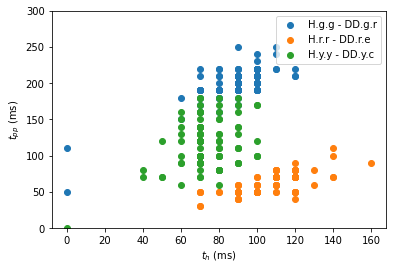

In [ ]:
plt.scatter(user1_df['H.g.g'],user1_df['DD.g.r'])
plt.scatter(user1_df['H.r.r'],user1_df['DD.r.e'])
plt.scatter(user1_df['H.y.y'],user1_df['DD.y.c'])
plt.xlabel("$t_{h}$ (ms)")
plt.ylabel("$t_{pp}$ (ms)")
plt.ylim(0,300)
plt.legend(['H.g.g - DD.g.r','H.r.r - DD.r.e','H.y.y - DD.y.c'])

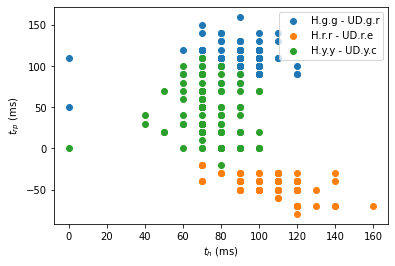

In [ ]:
plt.scatter(user1_df['H.g.g'],user1_df['DD.g.r']-user1_df['H.g.g'])
plt.scatter(user1_df['H.r.r'],user1_df['DD.r.e']-user1_df['H.r.r'])
plt.scatter(user1_df['H.y.y'],user1_df['DD.y.c']-user1_df['H.y.y'])
plt.xlabel("$t_{h}$ (ms)")
plt.ylabel("$t_{rp}$ (ms)")
plt.legend(['H.g.g - UD.g.r','H.r.r - UD.r.e','H.y.y - UD.y.c'])

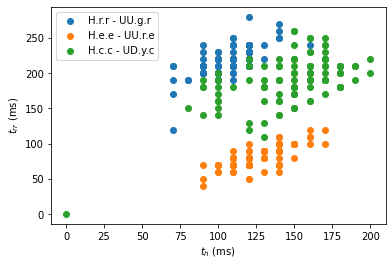

In [ ]:
plt.scatter(user1_df['H.r.r'],user1_df['DD.g.r']-user1_df['H.g.g']+user1_df['H.r.r'])
plt.scatter(user1_df['H.e.e'],user1_df['DD.r.e']-user1_df['H.r.r']+user1_df['H.e.e'])
plt.scatter(user1_df['H.c.c'],user1_df['DD.y.c']-user1_df['H.y.y']+user1_df['H.c.c'])
plt.xlabel("$t_{h}$ (ms)")
plt.ylabel("$t_{rr}$ (ms)")
plt.legend(['H.r.r - UU.g.r','H.e.e - UU.r.e','H.c.c - UD.y.c'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you

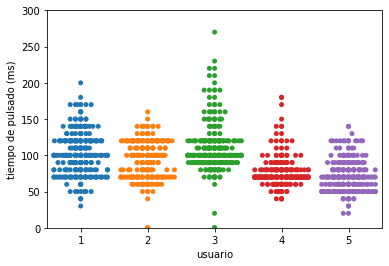

In [ ]:
import seaborn as sns
user15_df = user1_df.append(user2_df).append(user3_df).append(user4_df).append(user5_df).sample(n=100, random_state=1)
plt.figure()
for i in range(len(features)):
    feature = features[i]
    feature_type = feature.split(".")[0]
    if (feature_type == 'H'): 
      sns.swarmplot(x='Username',data=user15_df.iloc[0:100], y=feature)

plt.ylim(0,300)
plt.ylabel('tiempo de pulsado (ms)')
plt.xlabel('usuario')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you

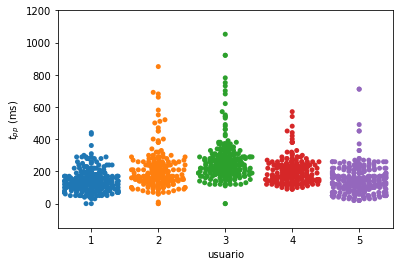

In [ ]:
plt.figure()
for i in range(len(features)):
    feature = features[i]
    feature_type = feature.split(".")[0]
    if (feature_type == 'DD'): 
      sns.swarmplot(x='Username',data=user15_df.iloc[0:100], y=feature)

plt.ylim(-150,1200)
plt.ylabel('$t_{pp}$ (ms)')
plt.xlabel('usuario')
plt.show()

Text(0, 0.5, 'usuario')

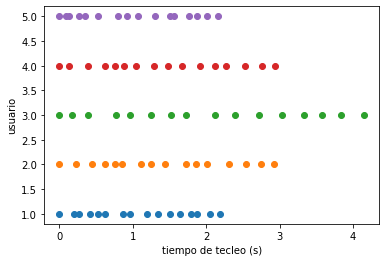

In [ ]:
features_df = initial_df.drop(labels=['Username'],axis=1)
y = df.Username
users = y.unique()
n_letters = 16
m,n = features_df.shape
plt.figure()
for user in users[:5]:
  user_features = features_df[df['Username']==user]
  user_pp =user_features.iloc[:,range(1,n,2)]
  user_samples, _ = user_features.shape
  mean_user_pp = np.sum(user_pp.values,axis=0)/user_samples
  N = len(mean_user_pp)
  user_typing_times = np.zeros(N+1)

  for i in range(N):
    user_typing_times[i+1] = user_typing_times[i] + mean_user_pp[i]
    
  
  y = user_typing_times*0+user
  plt.scatter(user_typing_times/1000, y)

plt.xlabel('tiempo de tecleo (s)')
plt.ylabel('usuario')

Text(0.5, 0, 'usuario')

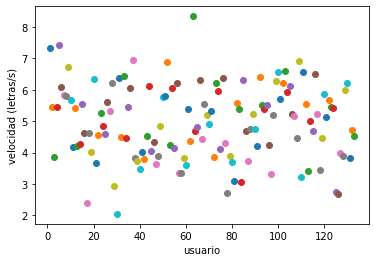

In [ ]:
features_df = initial_df.drop(labels=['Username'],axis=1)
y = initial_df.Username
users = y.unique()
n_letters = 16
plt.figure()
for user in users:
  user_features = features_df[df['Username']==user]
  user_pp =user_features.iloc[:,range(1,n,2)]
  user_samples, _ = user_features.shape
  mean_user_pp = np.sum(user_pp.values,axis=0)/user_samples
  N = len(mean_user_pp)
  user_typing_times = np.zeros(N+1)

  for i in range(N):
    user_typing_times[i+1] = user_typing_times[i] + mean_user_pp[i]
    
  total_user_typing_time = user_typing_times[N]
  velocity = n_letters/(total_user_typing_time/1000)
  plt.scatter(user, velocity)

plt.ylabel('velocidad (letras/s)')
plt.xlabel('usuario')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$t_{pp}$ (ms)')

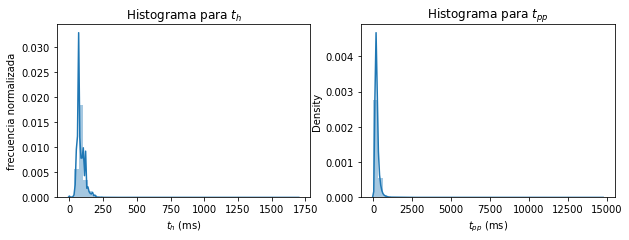

In [ ]:
# normed histogram
import seaborn as sns
plt.figure(figsize=(10,7))
ax1 = plt.subplot(2,2,1)
sns.distplot(df[hold_features],hist=True).set_title('Histograma para $t_h$')
ax1.set_xlabel('$t_h$ (ms)')
ax1.set_ylabel('frecuencia normalizada')
ax2 = plt.subplot(2,2,2)
sns.distplot(df[digraph_features],hist=True).set_title('Histograma para $t_{pp}$')
ax2.set_xlabel('$t_{pp}$ (ms)')

In [ ]:
df['H.g.g'].describe()

count    7524.000000
mean       88.347289
std        36.644252
min         0.000000
25%        70.000000
50%        80.000000
75%       100.000000
max       721.000000
Name: H.g.g, dtype: float64

In [ ]:
df['DD.g.r'].describe()

count    7524.000000
mean      193.341574
std       123.023324
min         0.000000
25%       130.000000
50%       190.000000
75%       230.000000
max      5328.000000
Name: DD.g.r, dtype: float64

Text(0, 0.5, 'tiempo (ms)')

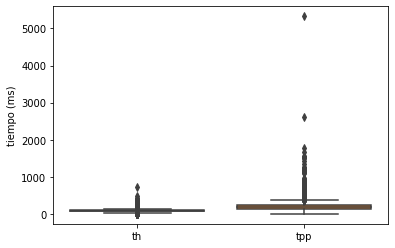

In [ ]:
hold_df = pd.DataFrame({'th': df['H.g.g']})
tmp_df =hold_df.assign( tpp = df['DD.g.r'])
sns.boxplot(x="variable", y="value", data=pd.melt(tmp_df))
plt.xlabel('')
plt.ylabel('tiempo (ms)')

Text(0, 0.5, "tiempo de pulsado para 'g'")

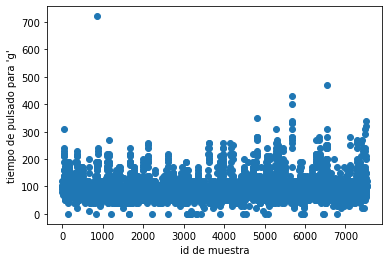

In [ ]:
plt.scatter(range(len(df['H.g.g'])),df['H.g.g'])
plt.xlabel("id de muestra")
plt.ylabel("tiempo de pulsado para 'g'")

## **ELIMINACIÓN DE ATÍPICOS**

In [ ]:
m,n = df.shape

In [ ]:
def outliers(x):
    return (abs(x-x.mean())<(3*x.std())).astype(int)

mask = df.iloc[:,0:(n-1)].apply(outliers, axis=0)
masked_df = mask.mask(mask == 1, df)
masked_df = masked_df.replace(0, np.nan)
masked_df['Username'] = df['Username']
df_no_outliers = masked_df.dropna(axis=0, how='any')

In [ ]:
df_no_outliers.head(5)

,H.g.g,DD.g.r,H.r.r,DD.r.e,H.e.e,DD.e.y,H.y.y,DD.y.c,H.c.c,DD.c.space,H.space.space,DD.space.l,H.l.l,DD.l.a,H.a.a,DD.a.b,H.b.b,DD.b.o,H.o.o,DD.o.r2,H.r2.r2,DD.r2.a,H.a2.a2,DD.a2.t,H.t.t,DD.t.o2,H.o2.o2,DD.o2.r3,H.r3.r3,DD.r3.y,H.y2.y2,velocity,Username
0,100.0,220.0,100.0,60.0,130.0,110.0,70.0,160.0,160.0,80.0,140.0,230.0,100.0,100.0,100.0,260.0,100.0,140.0,60.0,170.0,110.0,160.0,80.0,180.0,110.0,160.0,80.0,130.0,100.0,160.0,50.0,6.896552,1
1,120.0,210.0,100.0,50.0,120.0,270.0,70.0,160.0,90.0,210.0,100.0,340.0,70.0,140.0,90.0,260.0,90.0,140.0,70.0,120.0,100.0,170.0,90.0,180.0,100.0,170.0,90.0,210.0,100.0,150.0,60.0,5.755396,1
2,80.0,220.0,110.0,70.0,120.0,140.0,70.0,130.0,100.0,230.0,90.0,330.0,70.0,90.0,100.0,300.0,90.0,150.0,70.0,140.0,90.0,160.0,150.0,160.0,100.0,140.0,80.0,110.0,110.0,200.0,60.0,6.225681,1
3,100.0,210.0,120.0,70.0,120.0,190.0,70.0,170.0,100.0,160.0,100.0,260.0,80.0,150.0,120.0,300.0,100.0,150.0,70.0,140.0,90.0,140.0,100.0,220.0,90.0,110.0,100.0,220.0,70.0,160.0,80.0,6.037736,1
4,90.0,200.0,90.0,60.0,120.0,120.0,70.0,160.0,90.0,150.0,90.0,300.0,60.0,110.0,110.0,290.0,100.0,160.0,70.0,150.0,110.0,170.0,140.0,170.0,90.0,110.0,80.0,150.0,100.0,160.0,60.0,6.504065,1


Text(0, 0.5, "tiempo de pulsado para 'g'")

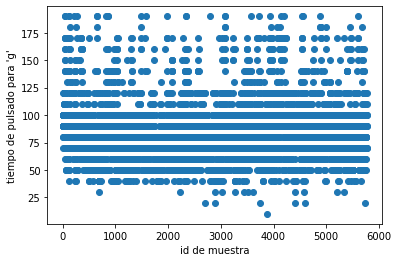

In [ ]:
plt.scatter(range(len(df_no_outliers['H.g.g'])),df_no_outliers['H.g.g'])
plt.xlabel("id de muestra")
plt.ylabel("tiempo de pulsado para 'g'")

Text(0, 0.5, 'tiempo (ms)')

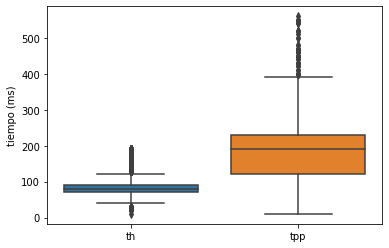

In [ ]:
mean_hold_df = pd.DataFrame({'th': df_no_outliers['H.g.g']})
mean_df = mean_hold_df.assign( tpp = df_no_outliers['DD.g.r'])
sns.boxplot(x="variable", y="value", data=pd.melt(mean_df))
plt.xlabel('')
plt.ylabel('tiempo (ms)')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$t_{pp}$ (ms)')

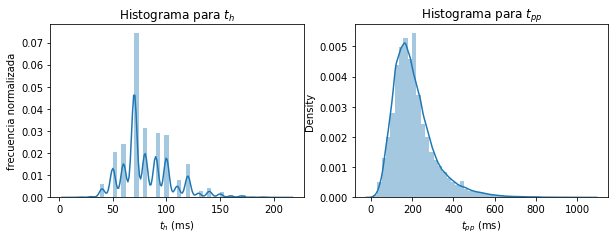

In [ ]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(2,2,1)
sns.distplot(df_no_outliers[hold_features],hist=True).set_title('Histograma para $t_h$')
ax1.set_xlabel('$t_h$ (ms)')
ax1.set_ylabel('frecuencia normalizada')
ax2 = plt.subplot(2,2,2)
sns.distplot(df_no_outliers[digraph_features],hist=True).set_title('Histograma para $t_{pp}$')
ax2.set_xlabel('$t_{pp}$ (ms)')

In [ ]:
df_no_outliers[hold_features].mean(axis=1).describe()

count    5772.000000
mean       81.577039
std        14.191292
min        41.333333
25%        71.333333
50%        80.000000
75%        90.666667
max       144.000000
dtype: float64

In [ ]:
df_no_outliers[digraph_features].mean(axis=1).describe()

count    5772.000000
mean      208.072901
std        51.155680
min       109.285714
25%       169.285714
50%       200.857143
75%       238.642857
max       480.714286
dtype: float64

In [ ]:
len(set(df_no_outliers.Username)), len(df_no_outliers)

(131, 5772)

## **3. ALGORITMOS CON SCIKIT-LEARN**

#### **RANDOM FOREST SCIKIT-LEARN**

In [ ]:
y = df_no_outliers.Username
X = df_no_outliers.drop(labels=['Username'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(len(list(set(y_train))),len(list(set(y_test))))

131 125


In [ ]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       0.93      1.00      0.97        14
           3       1.00      0.80      0.89         5
           4       1.00      0.92      0.96        13
           5       0.94      0.94      0.94        18
           6       0.62      1.00      0.77        10
           7       1.00      0.87      0.93        15
           8       1.00      0.90      0.95        20
           9       1.00      1.00      1.00         9
          10       1.00      0.94      0.97        16
          11       1.00      1.00      1.00        11
          12       0.72      1.00      0.84        13
          13       1.00      0.80      0.89         5
          14       1.00      0.80      0.89         5
          15       0.00      0.00      0.00         1
          16       0.70      1.00      0.82        14
          17       1.00      1.00      1.00         6
          18       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **NEURAL NETWORK SCIKIT-LEARN**

In [ ]:
y = df_no_outliers.Username
X = df_no_outliers.drop(labels=['Username'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(len(list(set(y_train))),len(list(set(y_test))))

131 129


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [ ]:
def plot_accuracy(history):
    plt.clf()   # clear figure
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'g', label='Training accuracy')
    plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
accuracies_1c = []
for n_neurons in [10,20,30,50,70,100,150,200,250,300,350,400,450,500]:
  model = models.Sequential()
  model.add(Dense(32, activation='relu', input_shape=(32,)))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(131, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train,
                      dummy_y_train,
                      epochs=200,
                      batch_size=256,
                      validation_data=(X_test, dummy_y_test))

  accuracies_1c.append(model.evaluate(X_test, dummy_y_test)[1])

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 108/200
19/19 [==============================] - 0s 4ms/step - loss: 2.4200 - accuracy: 0.3552 - val_loss: 2.7901 - val_accuracy: 0.3229
Epoch 109/200
19/19 [==============================] - 0s 4ms/step - loss: 2.3804 - accuracy: 0.3639 - val_loss: 2.7597 - val_accuracy: 0.3203
Epoch 110/200
19/19 [==============================] - 0s 5ms/step - loss: 2.3879 - accuracy: 0.3654 - val_loss: 2.7772 - val_accuracy: 0.3186
Epoch 111/200
19/19 [==============================] - 0s 5ms/step - loss: 2.3455 - accuracy: 0.3821 - val_loss: 2.8478 - val_accuracy: 0.3203
Epoch 112/200
19/19 [==============================] - 0s 5ms/step - loss: 2.3516 - accuracy: 0.3821 - val_loss: 2.7856 - val_accuracy: 0.3307
Epoch 113/200
19/19 [==============================] - 0s 4ms/step - loss: 2.3318 - accuracy: 0.3810 - val_loss: 2.9562 - val_accuracy: 0.3264
Epoch 114/200
19/19 [==============================] - 0s 4ms/step - loss: 2.3321

In [ ]:
neurons = [10,20,30,50,70,100,150,200,250,300,350,400,450,500]
accuracies_5c = []
for n_neurons in neurons:
  model = models.Sequential()
  model.add(Dense(32, activation='relu', input_shape=(32,)))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(131, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train,
                      dummy_y_train,
                      epochs=200,
                      batch_size=256,
                      validation_data=(X_test, dummy_y_test))

  accuracies_5c.append(model.evaluate(X_test, dummy_y_test)[1])

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 108/200
19/19 [==============================] - 0s 5ms/step - loss: 1.5408 - accuracy: 0.5744 - val_loss: 2.0591 - val_accuracy: 0.5065
Epoch 109/200
19/19 [==============================] - 0s 5ms/step - loss: 1.5613 - accuracy: 0.5712 - val_loss: 2.1715 - val_accuracy: 0.4632
Epoch 110/200
19/19 [==============================] - 0s 5ms/step - loss: 1.5749 - accuracy: 0.5651 - val_loss: 2.1071 - val_accuracy: 0.4866
Epoch 111/200
19/19 [==============================] - 0s 5ms/step - loss: 1.5585 - accuracy: 0.5644 - val_loss: 2.0139 - val_accuracy: 0.5134
Epoch 112/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4968 - accuracy: 0.5835 - val_loss: 2.0447 - val_accuracy: 0.5065
Epoch 113/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4931 - accuracy: 0.5902 - val_loss: 2.0340 - val_accuracy: 0.4961
Epoch 114/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4797

In [ ]:
neurons = [10,20,30,50,70,100,150,200,250,300,350,400,450,500]
accuracies_3c = []
for n_neurons in neurons:
  model = models.Sequential()
  model.add(Dense(32, activation='relu', input_shape=(32,)))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(131, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train,
                      dummy_y_train,
                      epochs=200,
                      batch_size=256,
                      validation_data=(X_test, dummy_y_test))

  accuracies_3c.append(model.evaluate(X_test, dummy_y_test)[1])

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 108/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4677 - accuracy: 0.5911 - val_loss: 2.1561 - val_accuracy: 0.4857
Epoch 109/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4370 - accuracy: 0.6060 - val_loss: 2.1829 - val_accuracy: 0.4918
Epoch 110/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4437 - accuracy: 0.5987 - val_loss: 2.1395 - val_accuracy: 0.5065
Epoch 111/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4234 - accuracy: 0.6028 - val_loss: 2.1460 - val_accuracy: 0.4987
Epoch 112/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4312 - accuracy: 0.5991 - val_loss: 2.1683 - val_accuracy: 0.4883
Epoch 113/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4060 - accuracy: 0.6060 - val_loss: 2.1312 - val_accuracy: 0.5013
Epoch 114/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4007

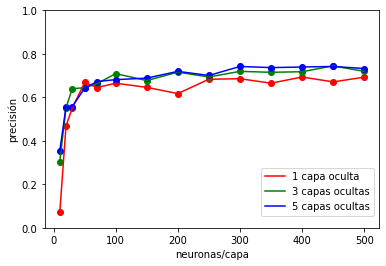

In [ ]:
plt.plot(neurons,accuracies_1c,c="red")
plt.plot(neurons,accuracies_3c,c="green")
plt.plot(neurons,accuracies_5c,c="blue")
plt.scatter(neurons,accuracies_1c,c="red")
plt.scatter(neurons,accuracies_3c,c="green")
plt.scatter(neurons,accuracies_5c,c="blue")
plt.xlabel('neuronas/capa')
plt.ylabel('precisión')
plt.ylim(0,1)
plt.legend(['1 capa oculta','3 capas ocultas','5 capas ocultas'],bbox_to_anchor=(1,0.3))

#### **KNN WITH SCIKIT-LEARN**

In [ ]:
X=df_no_outliers.drop(labels=['Username'], axis=1)
y = df_no_outliers.Username
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
clf = neighbors.KNeighborsClassifier(n_jobs=1,metric='minkowski',p=1)
clf.fit(X_train,y_train)

accuracy = clf.score(X_test,y_test)
accuracy

0.8484848484848485

## **KNN WITH MNKOWSKI DISTANCE FROM SCRATCH**

#### **Implementación**

In [ ]:
from collections import Counter

In [ ]:
def KNN(x, y, x_predict,k, p):
    n=0
    distances = []
    for _, features in x.iterrows():
        distance = np.power(np.sum(np.power(abs(np.array(features)-np.array(x_predict)),p)),1/p)
        distances.append([distance,y.iloc[n]])
        n=n+1

    votes = [i[1] for i in sorted(distances)[:k]]
    vote_result = Counter(votes).most_common(1)[0][0]
    return vote_result

In [ ]:
def knn_test(x_train,y_train,x_test,y_test,k,p):
    n=0
    correct = 0
    for _, pattern in x_test.iterrows():
        result = KNN(X_train,y_train,pattern,k,p)
    if (result == y_test.iloc[n]):
        correct = correct + 1
    n=n+1

    accuracy = correct/len(y_test)
    return accuracy

In [ ]:
X=df_no_outliers.drop(labels=['Username'], axis=1)
y = df_no_outliers.Username
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
knn_test(X_train,y_train,X_test,y_test,k=3,p=1)

0.8380952380952381

#### **optimización**

In [ ]:
for i in range(1,6,1):
  accuracy = knn_test(X_train,y_train,X_test,y_test,k=3,p=i)
  print(accuracy)

0.8658008658008658
0.7584415584415585
0.6926406926406926
0.6701298701298701
0.6476190476190476


In [ ]:
for i in [3,5,10,15,20]:
  accuracy = knn_test(X_train,y_train,X_test,y_test,k=i,p=1)
  print(accuracy)

0.8658008658008658
0.8761904761904762
0.8727272727272727
0.8571428571428571
0.8493506493506493
